### 1 Write paths
#### Dirpath: Directory path of synthesized facies models and global features

#### tfrecord_dir_training: directory to save training dataset
#### tfrecord_dir_test: directory to save test dataset

In [1]:
Dirpath = '/scratch/users/suihong/CaveSimulation/SimulatedModels/' 
tfrecord_dir_training = '/scratch/users/suihong/CaveSimulation/DatasetsforGAN_ave_3D/TrainingData'
tfrecord_dir_test = '/scratch/users/suihong/CaveSimulation/DatasetsforGAN_ave_3D/TestData'

### 2 Load facies models

In [2]:
import numpy as np
import tensorflow as tf
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Get all cave crops data from sim_cavecropsNNN_caveheightdistri.txt and rearrange them into an array. 
allele=[] 
comp_cave_sim_no = 642  # the number of complete cave simulations.
# Each complete big cave simulation is abstracted into multiple cave crops. Each crop contains part of the cave.
for i in range(1,comp_cave_sim_no):
    filepath = os.path.join(Dirpath, 'sim_cavecrops'+str(i)+'_caveheightdistri.txt')
    with open(filepath, 'r') as f:
        for line in f:
            eles = line.strip().split(',')
            allele.append(eles)

In [4]:
rlz_no = int(len(allele)/64)  # total cave crop realization number
print(rlz_no)
allimgs = np.array(allele, dtype = float).reshape((rlz_no, 64, 64)).astype(int)
allimgs = allimgs.reshape(-1, 1, 64, 64)

# For 3D, only use 11000 3d cave realizations to save memory, among which 10000 for training, 1000 for test.
random_seq=np.random.RandomState(232).permutation(rlz_no)
allimgs = allimgs[random_seq[:11000]]
print(allimgs.shape)

22695
(11000, 1, 64, 64)


In [5]:
# decide the void cell layers number below caves, or decide the center position of caves
heights_max = np.amax(allimgs, (1, 2, 3))
vcn = np.zeros((heights_max.shape[0],1))   #the void cell layers number below caves
for i in range(heights_max.shape[0]):
    if heights_max[i] >= 64:
        vcn[i] = 0
    else:
        vcn_max = 64 - heights_max[i]   
        vcn[i] = np.random.choice(vcn_max, 1)

In [6]:
print(vcn.shape)

(11000, 1)


In [7]:
allimgs_3d = np.tile(np.expand_dims(allimgs, axis=4), (1, 1, 1, 1, 64))  # with shape of [22695, 1, 64, 64, 64]
print(allimgs_3d.shape)

allcubes = np.zeros(([*allimgs.shape]+[64]), dtype=np.int) # with shape of [22695, 1, 64, 64, 64]
for i in range(64):
    allcubes[:,:,:,:,i] = i+1    

(11000, 1, 64, 64, 64)


In [8]:
vcn = vcn.reshape((11000, 1,1,1,1))
allcubes = allcubes - vcn
allcubes = np.where((allcubes>0) & (allcubes<allimgs_3d), 1, 0) * 255

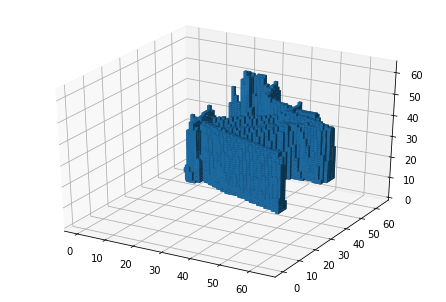

In [10]:
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
# and plot everything
fig = plt.figure()
ax = Axes3D(fig) #<-- Note the difference from your original code...

voxels = allcubes[654, 0]>0

ax.voxels(voxels)

plt.show()

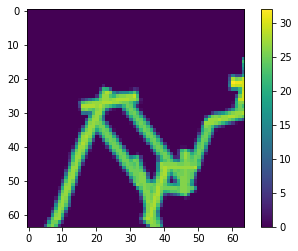

In [11]:
plt.imshow(allimgs[654,0])
plt.colorbar()

In [9]:
del(allele)
del(allimgs_3d)
del(vcn)

### 3 Generate probability maps

In [10]:
print((11000, 1, 64, 64, 64)) # Each 3D cave realization corresponds to 1 probability cubes with random smoothing kernels

(11000, 1, 64, 64, 64)


#### Probability of underground-river-related cave facies, if calculated from seismic data, also includes the probability of discrete unconnected small caves, thus should consider that factor. Not consider now.


In [11]:
def addnoise(cube):
    cube_noise = cube
    
    # (1) add noise within cave facies    
    if np.round(np.sum(cube)/200)>0:
        cave_indices = np.argwhere(cube>=0.9)
        cavenoisenumber = np.random.randint(0, np.round(np.sum(cube)/200))
        cave_noise_indices = np.random.randint(0, cave_indices.shape[0], cavenoisenumber)    
        cave_noise_coos = cave_indices[cave_noise_indices]
        cube_noise[cave_noise_coos[:, 0], cave_noise_coos[:, 1], cave_noise_coos[:, 2]] = (np.random.rand(cavenoisenumber) * 300+10) * (-1)
   
    # (2) add noise within non-cave facies
    noncavenoisenumber = np.random.randint(3, np.round((64*64*64 - np.sum(cube))/5600))
    noncave_indices = np.argwhere(cube<=0.1)
    noncave_noise_indices = np.random.randint(0, noncave_indices.shape[0], noncavenoisenumber)
    noncave_noise_coos = noncave_indices[noncave_noise_indices]
    cube_noise[noncave_noise_coos[:, 0], noncave_noise_coos[:, 1], noncave_noise_coos[:,2]] = np.random.rand(noncavenoisenumber) * 600
    
    return cube_noise

In [12]:
# Using Gaussian kernels with various size to smooth the indicator of underground-river-related cave facies to form the probability maps of caves with various blurriness. 
from scipy import ndimage

prob_rlzs = np.zeros((11000, 1, 64, 64, 64), dtype=np.float32) # dimension = [11000, 1, 64, 64, 64]  
k = np.random.choice([4, 6, 8, 10])
for num in range(11000):
    cur_cube = allcubes[num,0]/255

    cur_cube_withnoise = addnoise(cur_cube)
        
    padvalue = np.mean(cur_cube_withnoise)
    prob_cube = ndimage.gaussian_filter(cur_cube_withnoise, (k, k, 10*k), mode = 'constant', cval = padvalue) 
        
    if np.amax(prob_cube, axis = (0,1,2))<0.25:  # amplify the prob range beyond (0-0.25)
        prob_mx = np.random.rand(1)*0.75+0.25
        prob_cube = (prob_cube - np.amin(prob_cube, axis = (0,1,2))) * prob_mx/(np.amax(prob_cube, axis = (0,1,2)) - np.amin(prob_cube, axis = (0,1,2)))
       
    prob_cube = np.where(prob_cube>0.9, 0.9, prob_cube)
    prob_cube = np.where(prob_cube<0.02, 0.02, prob_cube)              
        
    prob_rlzs[num, 0] = prob_cube 

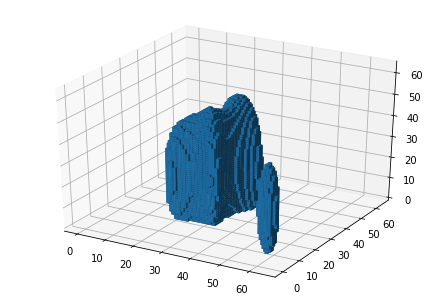

In [70]:

# and plot everything
fig = plt.figure()
ax = Axes3D(fig) #<-- Note the difference from your original code...

voxels = prob_rlzs[5,0]>0.4

ax.voxels(voxels)

plt.show()

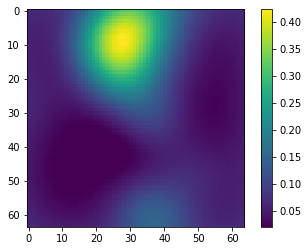

In [13]:
plt.imshow(prob_rlzs[9, 0,:,:, 28])
plt.colorbar()

(array([71735., 45893., 24445., 25765., 22240., 25882., 20190., 13211.,
         8673.,  4110.]),
 array([0.02      , 0.05281996, 0.08563992, 0.11845988, 0.15127984,
        0.1840998 , 0.21691976, 0.24973972, 0.28255968, 0.31537965,
        0.34819961]),
 <a list of 10 Patch objects>)

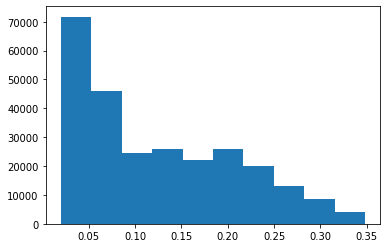

In [14]:
plt.hist(prob_rlzs[8, 0].reshape(-1))

In [65]:

#np.savetxt("/scratch/users/suihong/CaveSimulation/prob_test.txt", np.swapaxes(prob_rlzs[2, 0], 2, 0).reshape(-1), fmt='%.4e', delimiter="\n")

In [13]:
print(prob_rlzs.shape)

(11000, 1, 64, 64, 64)


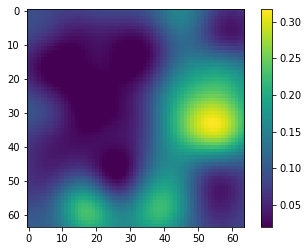

In [14]:
plt.imshow(prob_rlzs[10999, 0, :, :, 33])
plt.colorbar()

### 4 Generate well facies

In [15]:
# Generate random well points

well_points = np.zeros(prob_rlzs.shape, dtype = int)
for i in range(prob_rlzs.shape[0]):
    well_points_num = np.random.choice(np.arange(1, 40), 1)  # Random choose the expected total number of well points
    xs = np.random.choice(64, well_points_num)
    ys = np.random.choice(64, well_points_num)
    zs = np.random.choice(64, well_points_num)
    well_points[i, 0, xs, ys, zs] = 1

In [16]:
print(allcubes.shape)

(11000, 1, 64, 64, 64)


In [17]:
well_facies = allcubes/255 * well_points + well_points

In [18]:
print(well_facies.shape)

(11000, 1, 64, 64, 64)


#### Test synthesized well facies data

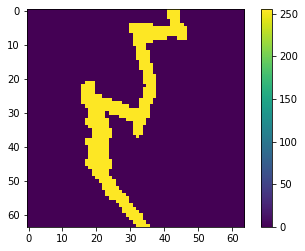

In [19]:
plt.imshow(allcubes[52,0,:,:, 30])
plt.colorbar()

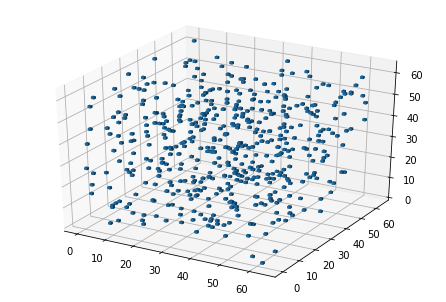

In [38]:
from mpl_toolkits.mplot3d import axes3d, Axes3D 
fig = plt.figure()
ax = Axes3D(fig) 

voxels = well_facies[394,0]>0

ax.voxels(voxels)

plt.show()

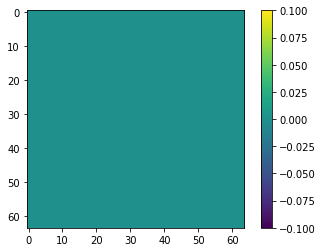

In [106]:
plt.imshow(well_facies[68,0,:,:, 20])
plt.colorbar()

### 5 Load labels (Global features)

In [20]:
# Abtain global features (all_labels_arr)
# There are 6 columns in each of the cave crops parameters file "sim_cavecrops_xx_paras.txt". 
# Correspondingly, the 6 columns represent following properties of each cave crop from 1st to 6th column:
# row of up-left point of the complete simulation with respect to the fracture density map; 
# column of of up-left point of the complete cave simulation with respect to the fracture density map; 
# average height of cave for this cave crop and also the complete cave simulation;
# average height-to-width ratio for this cave crop and also the complete cave simulation;
# row of up-left point of the this crop cave simulation with respect to the complete cave simulation;
# column of up-left point of the this crop cave simulation with respect to the complete cave simulation;

paraele=[]  

for i in range(1,comp_cave_sim_no):
    filepath = os.path.join(Dirpath, 'sim_cavecrops_'+str(i)+'_paras.txt')
    with open(filepath, 'r') as f:
        for line in f:
            eles = line.strip().split(',')
            paraele.append(eles)

all_labels_arr = np.array(paraele, dtype = float)
all_labels_arr = all_labels_arr[random_seq[:11000]]
print(all_labels_arr.shape)

(11000, 6)


In [21]:
labels_cor = np.empty((all_labels_arr.shape[0], 2), dtype=np.float)  

# width of underground-river related cave, calculated from height divided by height-to-width ratio.
labels_cor[:,0] = all_labels_arr[:,2]/all_labels_arr[:,3]  

back_ratio = 1-np.count_nonzero(allimgs, (1,2,3))/(64*64)
labels_cor[:,1] = back_ratio
# Set labels from -1 to 1 range.
# labels_cor[:,1] = ((back_ratio - np.min(back_ratio))/(np.max(back_ratio) - np.min(back_ratio)) - 0.5) * 2

(array([2105., 1438., 1182., 1843.,  750.,  517.,  722.,  679.,  389.,
         138.,  426.,   65.,  167.,  135.,  104.,    0.,   64.,  119.,
           0.,  157.]),
 array([36.1280985 , 38.67150252, 41.21490655, 43.75831057, 46.30171459,
        48.84511862, 51.38852264, 53.93192666, 56.47533069, 59.01873471,
        61.56213874, 64.10554276, 66.64894678, 69.19235081, 71.73575483,
        74.27915885, 76.82256288, 79.3659669 , 81.90937092, 84.45277495,
        86.99617897]),
 <a list of 20 Patch objects>)

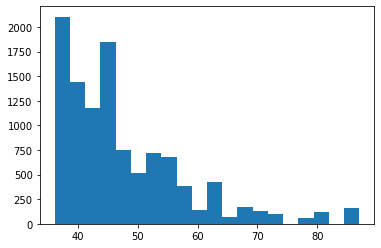

In [22]:
plt.hist(labels_cor[:,0], bins = 20)

### 6 Generate training and test datasets

In [23]:
# split facies models into training and test dataset
#randseq=np.random.RandomState(232).permutation(allcubes.shape[0])
allcubes_training = allcubes[:10000]
allcubes_test = allcubes[10000:]
print(allcubes_training.shape)
print(allcubes_test.shape)

(10000, 1, 64, 64, 64)
(1000, 1, 64, 64, 64)


In [24]:
# Corresponding split global features into training and test dataset
labels_cor_training = labels_cor[:10000]
labels_cor_test = labels_cor[10000:]
print(labels_cor_training.shape)
print(labels_cor_test.shape)

(10000, 2)
(1000, 2)


In [25]:
# Corresponding split prob and well cubes into training and test dataset
prob_rlzs_training = prob_rlzs[:10000]
prob_rlzs_test = prob_rlzs[10000:]

In [26]:
well_facies_training = well_facies[:10000]
well_facies_test = well_facies[10000:]

In [27]:
print(prob_rlzs_training.shape)

(10000, 1, 64, 64, 64)


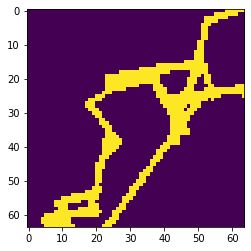

In [28]:
plt.imshow(allcubes_training[1225,0,:,:,30])

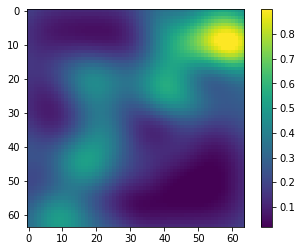

In [29]:
plt.imshow(prob_rlzs_training[1225,0,:,:,30])
plt.colorbar()

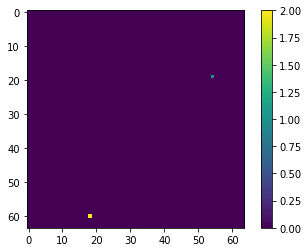

In [30]:
plt.imshow(well_facies_training[1225,0,:,:,30])
plt.colorbar()

#### Store training dataset

In [31]:
from scipy import stats
# copy from ProGAN github dataset_tools.py
class TFRecordExporter:
    def __init__(self, tfrecord_dir, expected_cubes, print_progress=True, progress_interval=10):
        self.tfrecord_dir       = tfrecord_dir
        self.tfr_prefix         = os.path.join(self.tfrecord_dir, os.path.basename(self.tfrecord_dir))
        self.expected_cubes    = expected_cubes
        self.cur_cubes         = 0
        self.shape              = None
        self.resolution_log2    = None
        self.tfr_writers        = []
        self.print_progress     = print_progress
        self.progress_interval  = progress_interval
        if self.print_progress:
            print('Creating dataset "%s"' % tfrecord_dir)
        if not os.path.isdir(self.tfrecord_dir):
            os.makedirs(self.tfrecord_dir)
        assert(os.path.isdir(self.tfrecord_dir))
        
    def close(self):
        if self.print_progress:
            print('%-40s\r' % 'Flushing data...', end='', flush=True)
        for tfr_writer in self.tfr_writers:
            tfr_writer.close()
        self.tfr_writers = []
        if self.print_progress:
            print('%-40s\r' % '', end='', flush=True)
            print('Added %d cubes.' % self.cur_cubes)

    def choose_shuffled_order(self): # Note: Cubes and labels must be added in shuffled order.
        order = np.arange(self.expected_cubes)
        np.random.RandomState(123).shuffle(order)
        return order

    def add_real_cube(self, real_cube):
        if self.print_progress and self.cur_cubes % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_cubes, self.expected_cubes), end='', flush=True)
        if self.shape is None:
            self.shape = real_cube.shape   # [1, 64, 64, 64]
            self.resolution_log2 = int(np.log2(self.shape[1]))  # 6
            assert self.shape[0] in [1, 3]
            assert self.shape[1] == self.shape[2]            
            assert self.shape[1] == 2**self.resolution_log2
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            for lod in range(self.resolution_log2 - 1):
                tfr_file = self.tfr_prefix + '-1r%02d.tfrecords' % (self.resolution_log2 - lod)
                self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        assert real_cube.shape == self.shape
        for lod, tfr_writer in enumerate(self.tfr_writers[:-1]):
            if lod:
                real_cube = real_cube.astype(np.float32)
                # used to produce low-D with averaging method
                real_cube = (real_cube[:, 0::2, 0::2, 0::2] + real_cube[:, 0::2, 1::2, 0::2] +real_cube[:, 1::2, 0::2, 0::2] +real_cube[:, 1::2, 1::2, 0::2] + 
                             real_cube[:, 0::2, 0::2, 1::2] + real_cube[:, 0::2, 1::2, 1::2] +real_cube[:, 1::2, 0::2, 1::2] +real_cube[:, 1::2, 1::2, 1::2])*0.125
            
            quant = np.rint(real_cube).clip(0, 255).astype(np.uint8)
            ex = tf.train.Example(features=tf.train.Features(feature={
                'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
                'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
            tfr_writer.write(ex.SerializeToString())
        self.cur_cubes += 1
        
        
    def add_labels(self, labels):
        if self.print_progress:
            print('%-40s\r' % 'Saving labels...', end='', flush=True)
        assert labels.shape[0] == self.cur_cubes
        with open(self.tfr_prefix + '-4rxx.labels', 'wb') as f:
            np.save(f, labels.astype(np.float32))

    def add_prob_cube(self, prob_cube):
        if self.print_progress and self.cur_cubes % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_cubes, self.expected_cubes), end='', flush=True)
        if self.shape is None:
            self.shape = prob_cube.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            # add probcubes writer into self.tfr_writers    
            tfr_file = self.tfr_prefix + '-2probcubes.tfrecords' 
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        # Writting prob_cube into tfrecord file
        quant = prob_cube.clip(0, 1).astype(np.float16)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_cubes += 1           

    def add_well_facies(self, well_facies):
        if self.print_progress and self.cur_cubes % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_cubes, self.expected_cubes), end='', flush=True)
        if self.shape is None:
            self.shape = well_facies.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            # add well_facies writer into self.tfr_writers    
            tfr_file = self.tfr_prefix + '-3wellfacies.tfrecords' 
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        # Writting well_facies into tfrecord file
        quant = well_facies.astype(np.uint8)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_cubes += 1               
            
    def __enter__(self):
        return self
    
    def __exit__(self, *args):
        self.close()

In [32]:
with TFRecordExporter(tfrecord_dir_training, allcubes_training.shape[0]) as tfr:
    order = tfr.choose_shuffled_order()
    for idx in range(order.size):
        tfr.add_real_cube(allcubes_training[order[idx]])
    tfr.add_labels(labels_cor_training[order])       

Creating dataset "/scratch/users/suihong/CaveSimulation/DatasetsforGAN_ave_3D/TrainingData"
Added 10000 cubes.                      


In [33]:
with TFRecordExporter(tfrecord_dir_training, prob_rlzs_training.shape[0]) as tfr:
    for idx in range(prob_rlzs_training.shape[0]):
        tfr.add_prob_cube(prob_rlzs_training[idx])     

Creating dataset "/scratch/users/suihong/CaveSimulation/DatasetsforGAN_ave_3D/TrainingData"
Added 10000 cubes.                      


In [34]:
with TFRecordExporter(tfrecord_dir_training, well_facies_training.shape[0]) as tfr:
    for idx in range(well_facies_training.shape[0]):
        tfr.add_well_facies(well_facies_training[idx])     

Creating dataset "/scratch/users/suihong/CaveSimulation/DatasetsforGAN_ave_3D/TrainingData"
Added 10000 cubes.                      


#### Store test dataset

In [35]:
with TFRecordExporter(tfrecord_dir_test, allcubes_test.shape[0]) as tfr:
    for idx in range(allcubes_test.shape[0]):
        tfr.add_real_cube(allcubes_test[idx])
    tfr.add_labels(labels_cor_test)       

Creating dataset "/scratch/users/suihong/CaveSimulation/DatasetsforGAN_ave_3D/TestData"
Added 1000 cubes.                       


In [36]:
with TFRecordExporter(tfrecord_dir_test, prob_rlzs_test.shape[0]) as tfr:
    for idx in range(prob_rlzs_test.shape[0]):
        tfr.add_prob_cube(prob_rlzs_test[idx])     

Creating dataset "/scratch/users/suihong/CaveSimulation/DatasetsforGAN_ave_3D/TestData"
Added 1000 cubes.                       


In [37]:
with TFRecordExporter(tfrecord_dir_test, well_facies_test.shape[0]) as tfr:
    for idx in range(well_facies_test.shape[0]):
        tfr.add_well_facies(well_facies_test[idx])     

Creating dataset "/scratch/users/suihong/CaveSimulation/DatasetsforGAN_ave_3D/TestData"
Added 1000 cubes.                       
